# 1. Import Necessary Libraries


In [22]:
# Import necessary libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical calculations
import geopandas as gpd  # For handling geographic data
import seaborn as sns  # For data visualization
import matplotlib.pyplot as plt  # For plotting
from sklearn.cluster import KMeans  # For K-Means clustering
import time  # For timing the code execution


# 2. Install GeoPandas and Upload Files


In [23]:
# Install GeoPandas and its dependencies if not already installed
!pip install geopandas

# Define file paths for Google Colaboratory
from google.colab import files

# Upload the CSV and Shapefile (you'll be prompted to upload files from your local system)
uploaded = files.upload()

# Assuming the uploaded files are named 'rm-yields-data.csv' and 'RuralMunicipality.zip'
yield_data_path = 'rm-yields-data.csv'
shapefile_path = 'RuralMunicipality.zip'

# Extract the shapefile if it's in a zip format
import zipfile
with zipfile.ZipFile(shapefile_path, 'r') as zip_ref:
    zip_ref.extractall('RuralMunicipality')


Saving rm_yield_00_23_major_crops.csv to rm_yield_00_23_major_crops.csv
Saving rm-yields-data.csv to rm-yields-data (1).csv
Saving RuralMunicipality.zip to RuralMunicipality (3).zip


# 3. Load Data


In [24]:
# Load the yield data from CSV
df_yields = pd.read_csv(yield_data_path)

# Load the geographic data from shapefile
gis_data_path = 'RuralMunicipality/RuralMunicipality.shp'
gdf_rms = gpd.read_file(gis_data_path)


# 4. Data Preprocessing


In [25]:
# Data Preprocessing
print("Columns in df_yields:", df_yields.columns.tolist())
print("Columns in gdf_rms:", gdf_rms.columns.tolist())

gdf_rms = gdf_rms.rename(columns={'RMNO': 'RM'})
df_yields['RM'] = df_yields['RM'].astype(str)
gdf_rms['RM'] = gdf_rms['RM'].astype(str)

if 'RM' not in df_yields.columns:
    print("The 'RM' column is not found in df_yields. Here are the available columns:")
    print(df_yields.columns.tolist())

if 'RM' not in gdf_rms.columns:
    print("The 'RM' column is not found in gdf_rms. Here are the available columns:")
    print(gdf_rms.columns.tolist())

columns_to_merge = df_yields.columns.difference(['Year'])
gdf_rms = gdf_rms.merge(df_yields[columns_to_merge], on='RM')
gdf_rms = gdf_rms[[col for col in gdf_rms.columns if not col.endswith('_x')]]
gdf_rms = gdf_rms.rename(columns=lambda x: x.replace('_y', ''))
print("Columns in gdf_rms after cleanup:", gdf_rms.columns.tolist())


Columns in df_yields: ['Year', 'RM', 'Winter Wheat', 'Canola', 'Spring Wheat', 'Mustard', 'Durum', 'Sunflowers', 'Oats', 'Lentils', 'Peas', 'Barley', 'Fall Rye', 'Canary Seed', 'Spring Rye', 'Tame Hay', 'Flax', 'Chickpeas']
Columns in gdf_rms: ['PPID', 'EFFDT', 'EXPDT', 'FEATURECD', 'RMNO', 'RMNM', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry']
Columns in gdf_rms after cleanup: ['PPID', 'EFFDT', 'EXPDT', 'FEATURECD', 'RM', 'RMNM', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry', 'Barley', 'Canary Seed', 'Canola', 'Chickpeas', 'Durum', 'Fall Rye', 'Flax', 'Lentils', 'Mustard', 'Oats', 'Peas', 'Spring Rye', 'Spring Wheat', 'Sunflowers', 'Tame Hay', 'Winter Wheat']


# 5. Exploratory Data Analysis (EDA)
## Yield Distribution


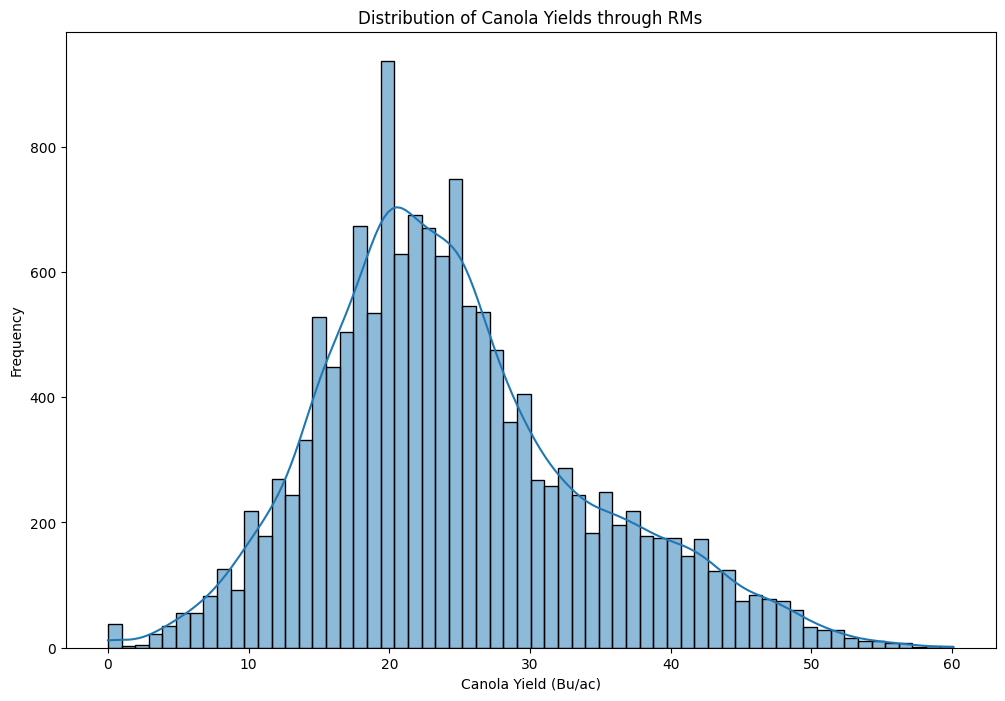

In [26]:
# Yield distribution through RMs
plt.figure(figsize=(12, 8))
sns.histplot(df_yields['Canola'], kde=True)
plt.title('Distribution of Canola Yields through RMs')
plt.xlabel('Canola Yield (Bu/ac)')
plt.ylabel('Frequency')
plt.show()


## Correlation Matrix


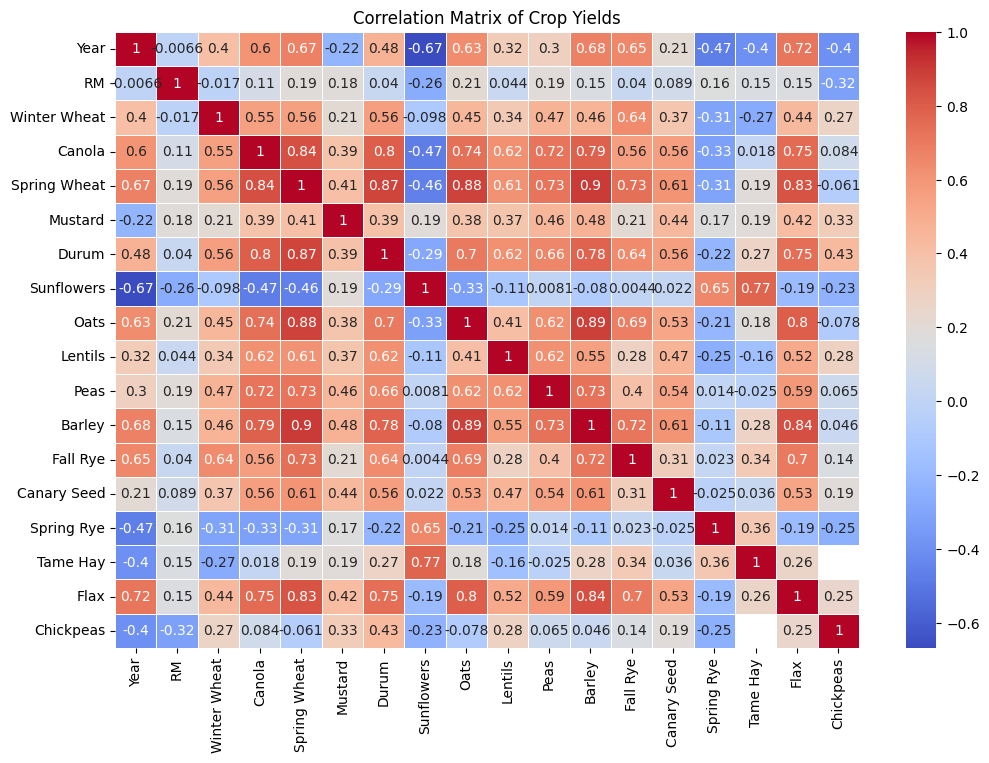

In [27]:
# Correlations between crop yields
plt.figure(figsize=(12, 8))
correlation_matrix = df_yields.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Crop Yields')
plt.show()


# 6. Clustering Analysis


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


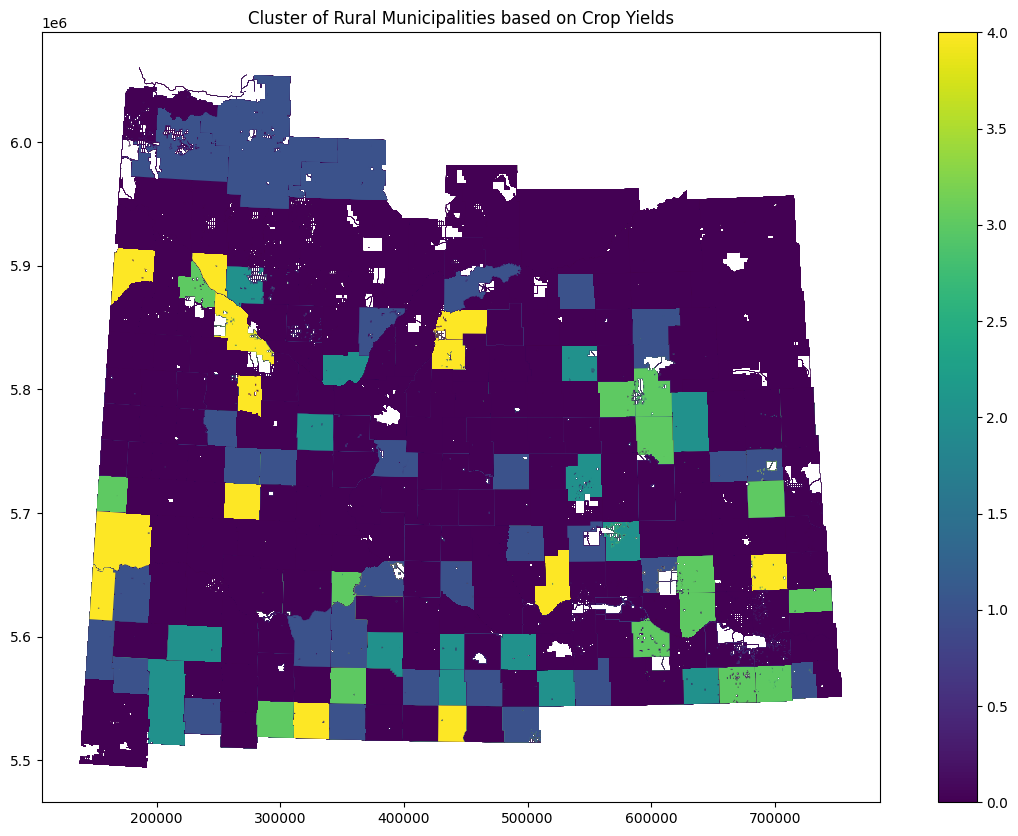

Cluster Summary:
                 Year   RM  Winter Wheat     Canola  Spring Wheat      Mustard  \
Cluster                                                                         
0        1975.788463  inf     38.776210  23.592906     25.040653   884.988867   
1        2004.785528  inf     31.083280  19.555812     25.300738   641.600061   
2        2011.162698  inf     42.185025  34.667419     41.280375  1015.352525   
3        2014.605042  inf     45.413958  33.437229     36.429026   884.007500   
4        2021.849057  inf     41.743077  33.092913     40.341704   662.736850   

             Durum  Sunflowers       Oats      Lentils       Peas     Barley  \
Cluster                                                                        
0        27.905972  721.605342  46.186791  1158.763220  32.045062  36.871631   
1        25.169420  712.530476  47.360981   697.915665  21.954340  37.947853   
2        41.723112  535.679200  71.894137  1706.441595  37.864280  60.049476   
3        40.98

In [28]:
# Clustering Analysis
features = df_yields.drop(['Year', 'RM'], axis=1)
features = features.fillna(features.mean())

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(features)

df_yields['Cluster'] = clusters
gdf_rms['Cluster'] = df_yields['Cluster']

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf_rms.plot(column='Cluster', cmap='viridis', legend=True, ax=ax)
plt.title('Cluster of Rural Municipalities based on Crop Yields')
plt.show()

cluster_summary = df_yields.groupby('Cluster').mean()
print("Cluster Summary:\n", cluster_summary)


# 7. Average Yield Trend for Each Cluster
## Plot Yield Trends: Plot the average yield trend for each cluster.


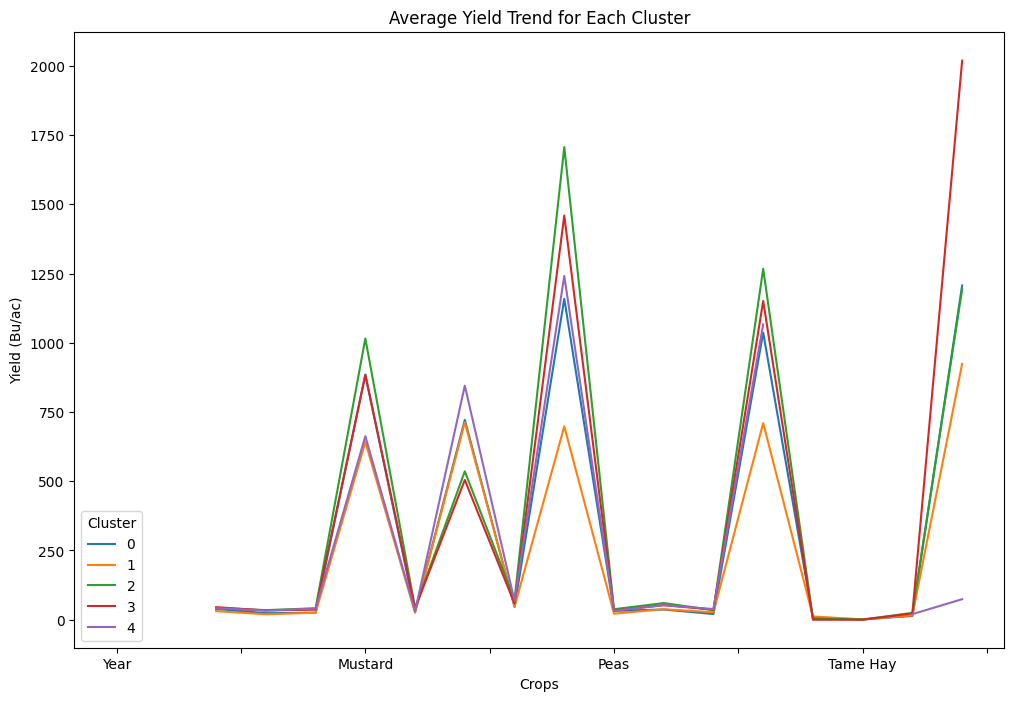

In [29]:
# Average Yield Trend for Each Cluster
cluster_summary_transposed = cluster_summary.transpose()
cluster_summary_transposed.plot(kind='line', figsize=(12, 8))
plt.title('Average Yield Trend for Each Cluster')
plt.xlabel('Crops')
plt.ylabel('Yield (Bu/ac)')
plt.legend(title='Cluster')
plt.show()


# 8. Geographic Analysis


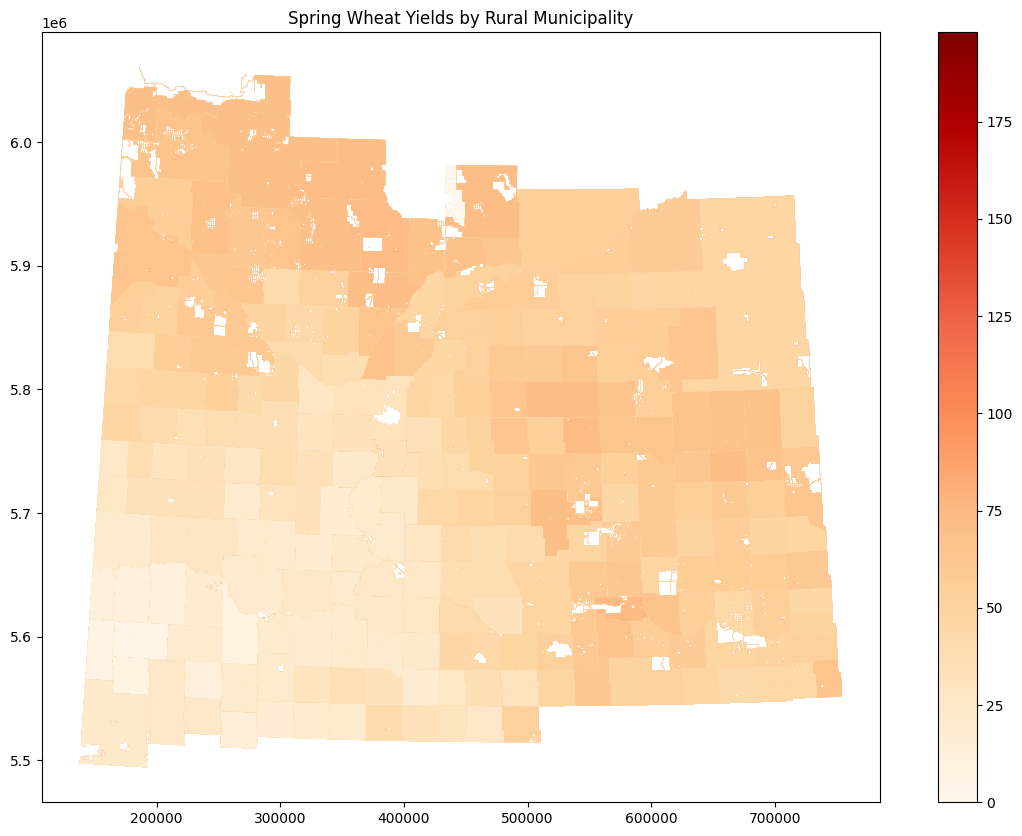

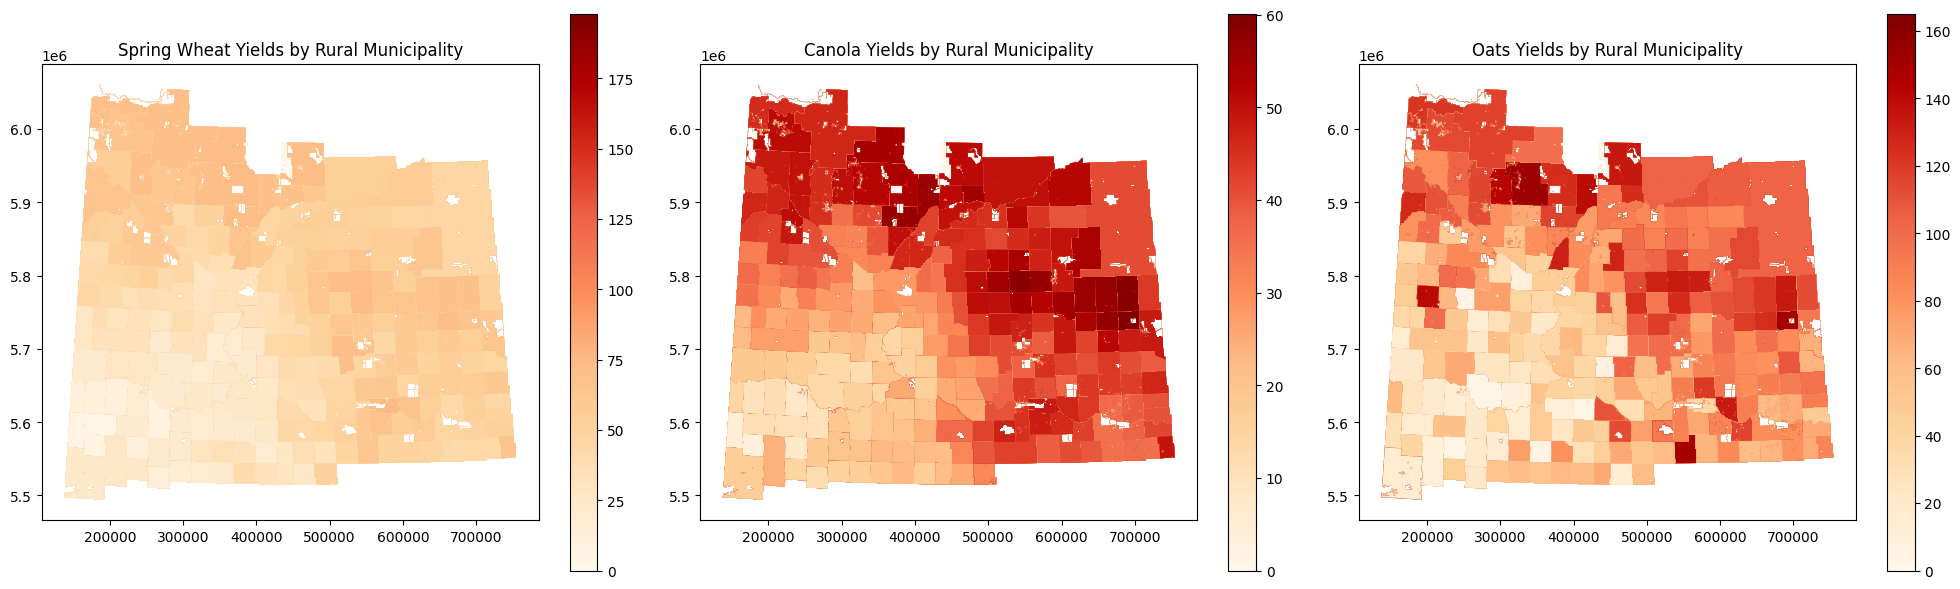

Geographic analysis execution time: 119.26407980918884 seconds


In [30]:
# Timing the Geographic Analysis for performance profiling
start_time = time.time()

# Geographic Analysis: Spring Wheat yields by Rural Municipality
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf_rms.plot(column='Spring Wheat', cmap='OrRd', legend=True, ax=ax)
plt.title('Spring Wheat Yields by Rural Municipality')
plt.show()

# Select a few representative crops to plot
selected_crops = ['Spring Wheat', 'Canola', 'Oats']

# Geographic Analysis: Selected crops by Rural Municipality
num_crops = len(selected_crops)
num_cols = 3
num_rows = (num_crops // num_cols) + (num_crops % num_cols > 0)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 6))
axs = axs.flatten()

for i, crop in enumerate(selected_crops):
    gdf_rms.plot(column=crop, cmap='OrRd', legend=True, ax=axs[i])
    axs[i].set_title(f'{crop} Yields by Rural Municipality')

# Remove any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

end_time = time.time()
print(f"Geographic analysis execution time: {end_time - start_time} seconds")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


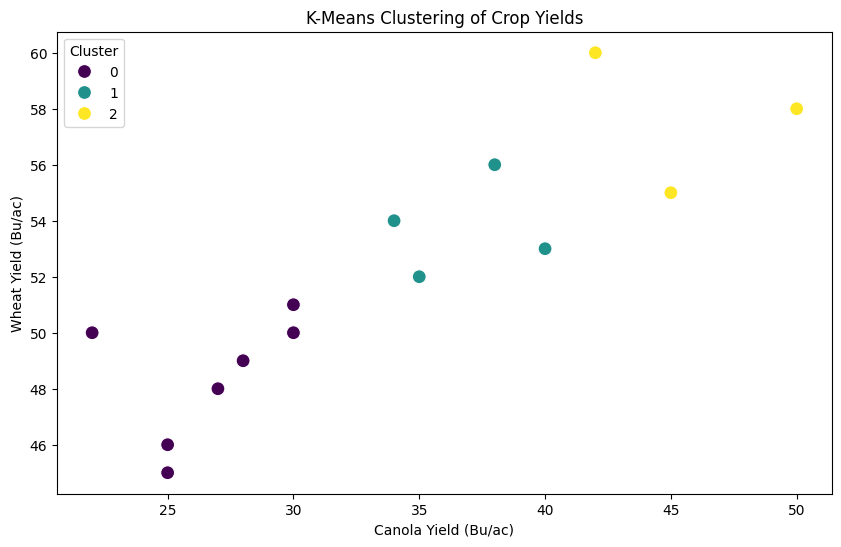

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Example Data (Replace this with your actual data)
data = {
    'Canola': [25, 30, 45, 22, 35, 50, 40, 28, 30, 34, 38, 42, 27, 25, 30],
    'Wheat': [45, 50, 55, 50, 52, 58, 53, 49, 50, 54, 56, 60, 48, 46, 51]
}
df_yields = pd.DataFrame(data)

# K-Means Clustering
kmeans = KMeans(n_clusters=3)
df_yields['Cluster'] = kmeans.fit_predict(df_yields)

# Plot Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_yields, x='Canola', y='Wheat', hue='Cluster', palette='viridis', s=100)
plt.title('K-Means Clustering of Crop Yields')
plt.xlabel('Canola Yield (Bu/ac)')
plt.ylabel('Wheat Yield (Bu/ac)')
plt.legend(title='Cluster')
plt.savefig('clustering_plot.png')
plt.show()
